In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from nsepy import get_history
from datetime import date

<AxesSubplot:xlabel='Date'>

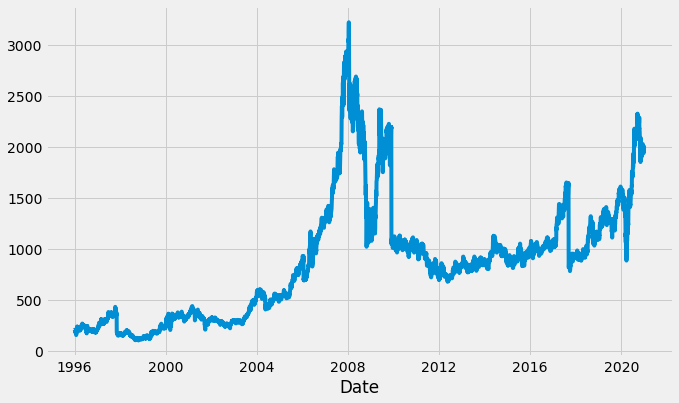

In [2]:
data=get_history(symbol='RELIANCE',start=date(1996,1,1),end=date(2020,12,31))
data['Close'].plot()

test stats                -1.816567
p-value                    0.372268
no of lags                31.000000
no of observations      6195.000000
Critical value (1%)       -3.431406
Critical value (5%)       -2.862007
Critical value (10%)      -2.567018
dtype: float64


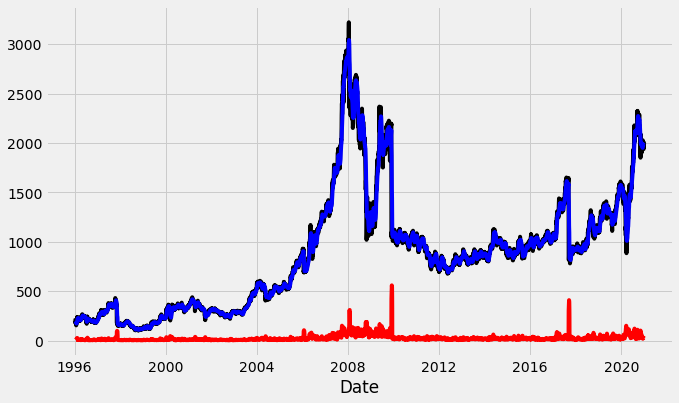

In [3]:
def stationarity(df):
    rollmean=df.rolling(12).mean()
    rollstd=df.rolling(12).std()
    df.plot(color='black')
    rollmean.plot(color='blue')
    rollstd.plot(color='red')
    adf=adfuller(df,autolag='AIC')
    output=pd.Series(adf[:4],index=['test stats','p-value','no of lags','no of observations'])
    for key,val in adf[4].items():
        output['Critical value (%s)' %key]=val
    print(output)
    
stationarity(data['Close'])

<AxesSubplot:xlabel='Date'>

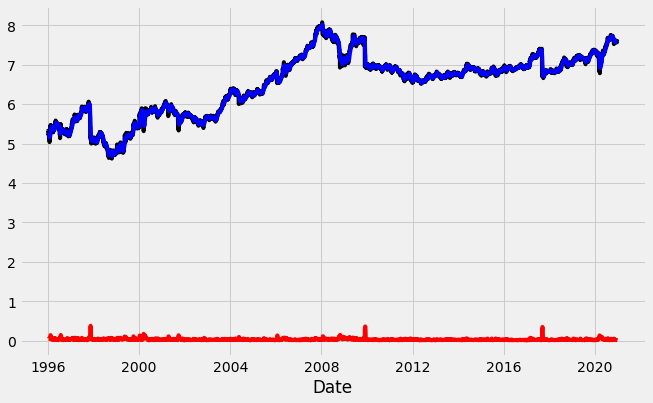

In [6]:
df_log=np.log(data['Close'])
rollmean=df_log.rolling(12).mean()
rollstd=df_log.rolling(12).std()
df_log.plot(color='black')
rollmean.plot(color='blue')
rollstd.plot(color='red')

<AxesSubplot:xlabel='Date'>

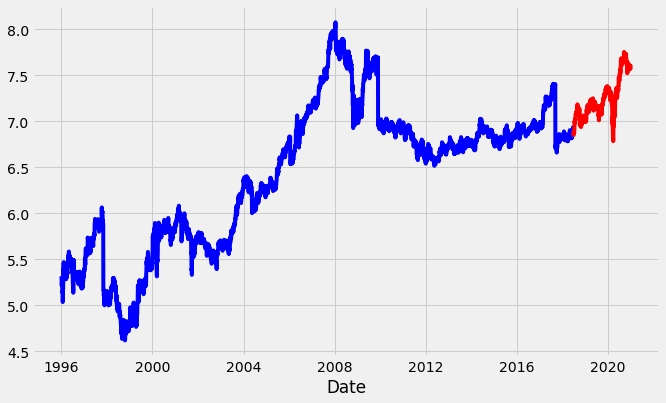

In [18]:
div=int(len(df_log)*0.9)
train,test=[df_log[3:div],df_log[div:]]
train.plot(color='blue')
test.plot(color='red')

In [23]:
model=auto_arima(train,start_p=0,start_q=0,test='adf',
                max_p=3,max_q=3,m=1,d=None,D=0,start_P=0,
                seasonal=False,trace=True,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24007.829, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24013.846, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24014.067, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24009.264, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24012.832, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-24013.031, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-24011.014, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24015.543, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-24014.298, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-24014.492, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-24015.323, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-24012.470, Time=0.51 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.632 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5601
Model:               SARIMAX(0, 1, 1)   Log Likelihood               12009.772
Date:                Tue, 10 Jan 2023   AIC                         -24015.543
Time:                        01:37:15   BIC                         -24002.282
Sample:                             0   HQIC                        -24010.922
                               - 5601                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0380      0.011      3.411      0.001       0.016       0.060
sigma2         0.0008   1.52e-06    529.161      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9248073.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -8.02
Prob(H) (two-sided):                  0.00   Kurtosis:                       201.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

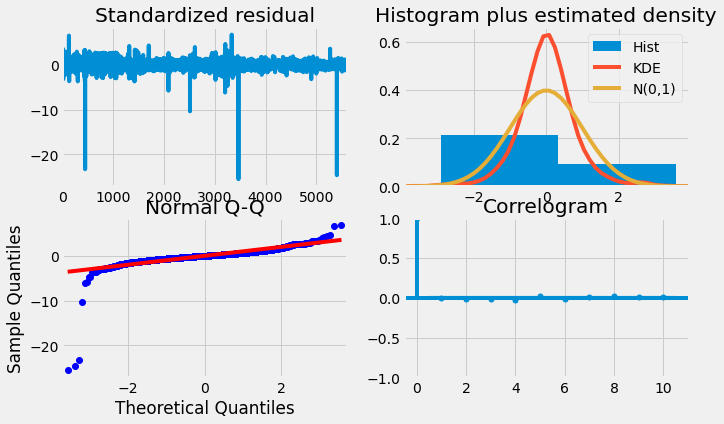

In [25]:
model.plot_diagnostics()
plt.show()

In [28]:
arima_model=ARIMA(train,order=(0,1,1))
fitted=arima_model.fit(disp=-1)
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 5600
Model:                 ARIMA(0, 1, 1)   Log Likelihood               12010.036
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 10 Jan 2023   AIC                         -24014.072
Time:                        01:41:42   BIC                         -23994.181
Sample:                             1   HQIC                        -24007.140
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      0.724      0.469      -0.000       0.001
ma.L1.D.Close     0.0389      0.014      2.875      0.004       0.012       0.065
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1          -25.7242           +0.0000j           25.7242            0.5000
-----------------------------------------------------------------------------
"""

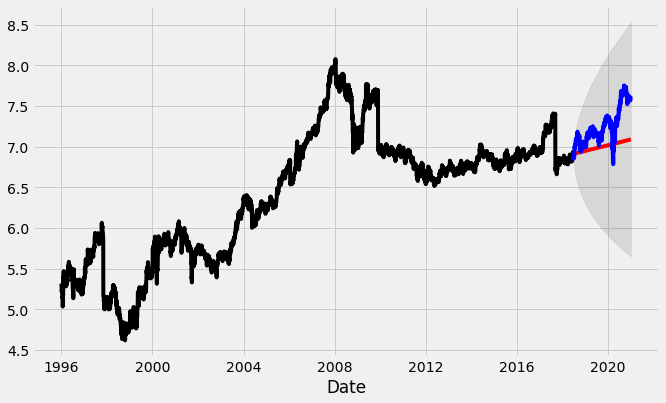

In [38]:
fc,se,conf=fitted.forecast(623,alpha=0.05)
fc_series=pd.Series(fc,index=test.index)
lower=pd.Series(conf[:,0],index=test.index)
upper=pd.Series(conf[:,1],index=test.index)
train.plot(color='black')
fc_series.plot(color='red')
test.plot(color='blue')
plt.fill_between(lower.index, lower, upper, 
                 color='k', alpha=.10)
plt.show()

In [34]:
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 0.09942758137862426
MAE: 0.2621037524659064
RMSE: 0.3153213937851732
MAPE: 0.03543587421061901
